In [1]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
import pandas
import math
import json
import numpy as np
import sklearn
from sklearn.metrics import confusion_matrix

In [9]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt



In [10]:
contents = pandas.read_csv('out_final.csv')

In [11]:
import matplotlib.pyplot as plt

In [12]:
def add_to_dict(dic, val):
    if val not in dic.keys():
        dic[val] = 1
    else:
        dic[val] += 1

In [13]:
all_ages = {}
all_gender = {}
all_educations = {}
all_workerid = []
all_rows = 0
for row in contents.iterrows():
    row_data = row[1]['datastring']
    if isinstance(row_data,str):
        all_workerid.append(row[1].workerid)
        all_rows+=1
        json_data = json.loads(row_data)
        add_to_dict(all_ages, json_data['questiondata']['age'])
        add_to_dict(all_gender,json_data['questiondata']['gender'])
        add_to_dict(all_educations,json_data['questiondata']['education'])

In [14]:
len(all_workerid)

79

In [15]:
len(set(all_workerid))

79

In [16]:
all_ages

{'26-30': 8, '31-35': 18, '36-40': 11, '41-45': 17, '45-50': 25}

In [17]:
all_ages_ = {}
all_ages_['35-45'] = all_ages['36-40'] + all_ages['41-45']
all_ages_['<35'] = all_ages['26-30'] + all_ages['31-35']
all_ages_['>45'] = all_ages['45-50']

In [18]:
all_ages_

{'35-45': 28, '<35': 26, '>45': 25}

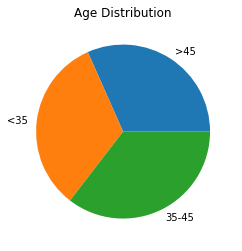

In [19]:
plt.pie(all_ages_.values(), labels = all_ages_.keys())
plt.title('Age Distribution')
plt.show() 

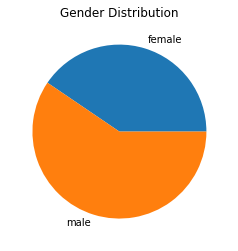

In [20]:
plt.pie(all_gender.values(), labels = all_gender.keys())
plt.title('Gender Distribution')
plt.show() 

In [21]:
all_gender

{'female': 32, 'male': 47}

In [22]:
all_educations_ = {}
all_educations_['Below Bachelors'] = all_educations['high school']
all_educations_['Bachelors'] = all_educations['bachelor']
all_educations_['Above Bachelors'] = all_educations['master'] + all_educations['pg']

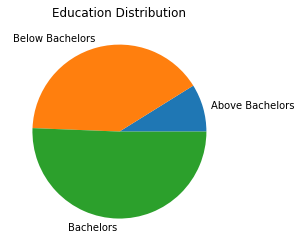

In [23]:
plt.pie(all_educations_.values(), labels = all_educations_.keys())
plt.title('Education Distribution')
plt.show() 

In [24]:
all_educations_

{'Above Bachelors': 7, 'Bachelors': 40, 'Below Bachelors': 32}

In [19]:
page_to_class = {}
page_to_class['a'] = 'H'
page_to_class['b'] = 'AI'
page_to_class['c'] = 'AI'
page_to_class['d'] = 'AI'
page_to_class['e'] = 'AI'

page_to_algo = {}
page_to_algo['a'] = 'humans'
page_to_algo['b'] = 'azure'
page_to_algo['c'] = 'detectron'
page_to_algo['d'] = 'google'
page_to_algo['e'] = 'rekognition'

In [20]:
all_gender

{'female': 32, 'male': 47}

In [21]:
all_educations.keys()

dict_keys(['bachelor', 'high school', 'master', 'pg'])

In [22]:
def parse_all_data(contents,allowed_algos = ['humans', 'azure', 'detectron', 'google', 'rekognition'], allowed_ages = all_ages.keys(), allowed_genders = all_gender.keys(), allowed_educations = all_educations.keys()):
    person_to_personal_df = {}   
    for row in contents.iterrows():
        row_data = row[1]['datastring']
        if isinstance(row_data,str):
            json_data = json.loads(row_data)
            person_id = json_data['workerId']
            person_questionnaire = json_data['questiondata']
            person_age = person_questionnaire['age']
            person_gender = person_questionnaire['gender']
            person_education = person_questionnaire['education']
            person_df = pandas.DataFrame(columns = ['image','topic_match','response_class','actual_class','class_match','response_gender'])
            for i in range(1,26):
                ques_output = {}
                ques_response = json_data['data'][i]['trialdata']
                image = ques_response['imageID']
                topic_match = int(ques_response['topic']) == int(ques_response['oneWord_curr']) + 1
                
                response_class = ques_response['Aclass']
                actual_class = page_to_class[ques_response['page_name'].split('_')[1]]
                class_match = response_class == actual_class

                response_gender = ques_response['Agender']
                algo = page_to_algo[ques_response['page_name'].split('_')[1]]
                page_name = ques_response['page_name']
                if algo in allowed_algos and person_age in allowed_ages and person_gender in allowed_genders and person_education in allowed_educations:
                    person_df = person_df.append({'image' : image, 'topic_match' : topic_match, 'response_class' : response_class,'actual_class':actual_class, 'class_match':class_match, 'response_gender': response_gender, 'page_name': page_name},ignore_index = True)
            if len(person_df) > 0:
                person_to_personal_df[person_id] = person_df
    return person_to_personal_df

In [23]:
def run_analysis(person_to_personal_df, verbose = False):
    prediction_accs = []
    topic_accs = []
    all_images = []
    all_actuals = []
    all_response_classes = []
    all_genders = []
    
    result_mean = []
    result_std = [] #std for individual categories: e.g. humans alone, AI alone, each model alone
    top_std = [] 

    for person_id in person_to_personal_df.keys():
        person_df = person_to_personal_df[person_id]
        all_images.extend(list(person_df['image']))
        all_actuals.extend(list(person_df['actual_class']))
        all_response_classes.extend(list(person_df['response_class']))
        all_genders.extend(list(person_df['response_gender']))

        topic_accuracy = np.sum(person_df['topic_match'])/len(person_df['topic_match'])
        prediction_accuracy = np.sum(person_df['class_match'])/len(person_df['class_match'])
        topic_accs.append(topic_accuracy)
        prediction_accs.append(prediction_accuracy)
    
    if verbose:
        print('Mean Topic Prediction:%s'%np.mean(topic_accs))
        print('Mean AI/H Prediction:%s'%np.mean(prediction_accs))
        print('Female prediction rate:%s'%(all_genders.count('F')/len(all_genders)))
    
    h_h = 0
    h_ai = 0
    ai_h = 0
    ai_ai = 0
    
    result = {'human':0, 'countH':0, 'list_human':[], 'machine':0, 'countM': 0, 'list_machine':[]} #machine is overall AI; countM is the total num of AI ground truth
    
    all_actuals_gts = [all_actuals, all_response_classes,all_images]
    for i in range(len(all_actuals)):
        if all_actuals[i] == 'H':
            result['countH'] += 1
            if all_response_classes[i] == 'H':
                h_h += 1
                result['human'] += 1
                result['list_human'].append(1)
            if all_response_classes[i] == 'AI':
                h_ai += 1
                result['list_human'].append(0)
        if all_actuals[i] == 'AI':
            result['countM'] += 1
            if all_response_classes[i] == 'H':
                ai_h += 1
                result['list_machine'].append(0)
            if all_response_classes[i] == 'AI':
                ai_ai += 1
                result['machine'] += 1
                result['list_machine'].append(1)
                
    confusion_df = pandas.DataFrame([[h_h/(h_h+h_ai), h_ai/(h_h+h_ai)], [ai_h/(ai_h+ai_ai), ai_ai/(ai_h+ai_ai)]], columns=['H','AI'], index=['H', 'AI'])
    if verbose:
        print(confusion_df)
    
    result_mean.append(sum(result['list_human'])/len(result['list_human']))
    result_std.append(np.std(np.array(result['list_human']), axis=0))
    result_mean.append(sum(result['list_human'])/len(result['list_human']))
    result_std.append(np.std(np.array(result['list_human']), axis=0))
    top_std.append(boostrap(result['list_human'], result['list_machine']))
    return np.mean(prediction_accs),confusion_df, all_actuals_gts, top_std 

In [24]:
def boostrap(data1, data2):
    import random
    import math
    store = []
    sample_mean = []
    if len(data1) < len(data2):
        SampleTimes = math.ceil(len(data1)/2)
        BootstrapTimes = len(data1)
    else:
        SampleTimes = math.ceil(len(data2)/2)
        BootstrapTimes = len(data2)
        
    #print(BootstrapTimes)        
    for i in range(BootstrapTimes):
        y1 = random.sample(data1, SampleTimes)
        #print(y1)
        y2 = random.sample(data2, SampleTimes)
        #print(y2)
        y_comb = y1+y2
        #print(y_comb)
        sample_mean.append(np.mean(np.array(y_comb), axis=0))
    
    stdval = np.std(np.array(sample_mean), axis=0)
    return stdval

# Humans vs All

In [25]:
means = {}
dfs = {}
results = {}
stds = {}

means['all'] = {}
means['azure'] = {}
means['detectron'] = {}
means['google'] = {}
means['rekognition'] = {}

dfs['all'] = {}
dfs['azure'] = {}
dfs['detectron'] = {}
dfs['google'] = {}
dfs['rekognition'] = {}

results['all'] = {}
results['azure'] = {}
results['detectron'] = {}
results['google'] = {}
results['rekognition'] = {}

stds['all'] = {}
stds['azure'] = {}
stds['detectron'] = {}
stds['google'] = {}
stds['rekognition'] = {}

In [26]:
print('starting overall...')
parsed_data = parse_all_data(contents)
means['all']['all'], dfs['all']['all'],results['all']['all'],stds['all']['all'] = run_analysis(parsed_data)

starting overall...


In [27]:
# Age
print('starting age...')
parsed_data = parse_all_data(contents,allowed_ages=['26-30','31-35'])
means['all']['all_35'], dfs['all']['all_35'],results['all']['all_35'],stds['all']['all_35'] = run_analysis(parsed_data)

parsed_data = parse_all_data(contents,allowed_ages=['36-40','41-45'])
means['all']['all_35_45'], dfs['all']['all_35_45'],results['all']['all_35_45'],stds['all']['all_35_45'] = run_analysis(parsed_data)

parsed_data = parse_all_data(contents,allowed_ages=['45-50'])
means['all']['all_45'], dfs['all']['all_45'],results['all']['all_45'],stds['all']['all_45'] = run_analysis(parsed_data)

# Education
print('starting education...')
parsed_data = parse_all_data(contents,allowed_educations=['high school'])
means['all']['all_edu_1'], dfs['all']['all_edu_1'],results['all']['all_edu_1'],stds['all']['all_edu_1'] = run_analysis(parsed_data)

parsed_data = parse_all_data(contents,allowed_educations=['bachelor'])
means['all']['all_edu_2'], dfs['all']['all_edu_2'],results['all']['all_edu_2'],stds['all']['all_edu_2'] = run_analysis(parsed_data)

parsed_data = parse_all_data(contents,allowed_educations=['master','pg'])
means['all']['all_edu_3'], dfs['all']['all_edu_3'],results['all']['all_edu_3'],stds['all']['all_edu_3'] = run_analysis(parsed_data)

# Gender
print('starting gender...')
parsed_data = parse_all_data(contents,allowed_genders=['male'])
means['all']['all_male'], dfs['all']['all_male'],results['all']['all_male'],stds['all']['all_male'] = run_analysis(parsed_data)

parsed_data = parse_all_data(contents,allowed_genders=['female'])
means['all']['all_female'], dfs['all']['all_female'],results['all']['all_female'],stds['all']['all_female'] = run_analysis(parsed_data)

starting age...
starting education...
starting gender...


# Humans vs Azure

In [28]:
for ALGO in ['azure','detectron','google','rekognition']:
    print(ALGO)
    print('starting overall...')
    parsed_data = parse_all_data(contents, allowed_algos=['humans',ALGO])
    means[ALGO]['all'], dfs[ALGO]['all'], results[ALGO]['all'], stds[ALGO]['all'] = run_analysis(parsed_data)

    # Age
    print('starting age...')
    parsed_data = parse_all_data(contents,allowed_ages=['26-30','31-35'], allowed_algos=['humans',ALGO])
    means[ALGO]['all_35'], dfs[ALGO]['all_35'], results[ALGO]['all_35'], stds[ALGO]['all_35'] = run_analysis(parsed_data)

    parsed_data = parse_all_data(contents,allowed_ages=['36-40','41-45'], allowed_algos=['humans',ALGO])
    means[ALGO]['all_35_45'], dfs[ALGO]['all_35_45'], results[ALGO]['all_35_45'], stds[ALGO]['all_35_45'] = run_analysis(parsed_data)

    parsed_data = parse_all_data(contents,allowed_ages=['45-50'], allowed_algos=['humans',ALGO])
    means[ALGO]['all_45'], dfs[ALGO]['all_45'], results[ALGO]['all_45'], stds[ALGO]['all_45'] = run_analysis(parsed_data)

    # Education
    print('starting education...')
    parsed_data = parse_all_data(contents,allowed_educations=['high school'], allowed_algos=['humans',ALGO])
    means[ALGO]['all_edu_1'], dfs[ALGO]['all_edu_1'], results[ALGO]['all_edu_1'], stds[ALGO]['all_edu_1'] = run_analysis(parsed_data)

    parsed_data = parse_all_data(contents,allowed_educations=['bachelor'], allowed_algos=['humans',ALGO])
    means[ALGO]['all_edu_2'], dfs[ALGO]['all_edu_2'], results[ALGO]['all_edu_2'], stds[ALGO]['all_edu_2'] = run_analysis(parsed_data)

    parsed_data = parse_all_data(contents,allowed_educations=['master','pg'], allowed_algos=['humans',ALGO])
    means[ALGO]['all_edu_3'], dfs[ALGO]['all_edu_3'], results[ALGO]['all_edu_3'], stds[ALGO]['all_edu_3'] = run_analysis(parsed_data)

    # Gender
    print('starting gender...')
    parsed_data = parse_all_data(contents,allowed_genders=['male'], allowed_algos=['humans',ALGO])
    means[ALGO]['all_male'], dfs[ALGO]['all_male'], results[ALGO]['all_male'], stds[ALGO]['all_male'] = run_analysis(parsed_data)

    parsed_data = parse_all_data(contents,allowed_genders=['female'], allowed_algos=['humans',ALGO])
    means[ALGO]['all_female'], dfs[ALGO]['all_female'], results[ALGO]['all_female'], stds[ALGO]['all_female'] = run_analysis(parsed_data)


    # parsed_data = parse_all_data(contents,['humans','azure'])
    # means['azure'], dfs['azure'] = run_analysis(parsed_data)

azure
starting overall...
starting age...
starting education...
starting gender...
detectron
starting overall...
starting age...
starting education...
starting gender...
google
starting overall...
starting age...
starting education...
starting gender...
rekognition
starting overall...
starting age...
starting education...
starting gender...


In [54]:
import pickle
all_H_accuracies = {}
for key_1 in results.keys():
    all_H_accuracies[key_1] = {}
    for key_2 in results[key_1].keys():
        image_H_accuracy = {}
        all_actuals_H,all_responses_H,all_images_H = results[key_1][key_2]
        all_H_accuracy = (np.array(all_actuals_H) == np.array(all_responses_H)).astype('int')
        for im_ct in range(len(all_images_H)):
            im = all_images_H[im_ct]
            if im not in image_H_accuracy.keys(): 
                image_H_accuracy[im] = [all_actuals_H[im_ct] == all_responses_H[im_ct]]
            else:
                image_H_accuracy[im].append(all_actuals_H[im_ct] == all_responses_H[im_ct])
        all_H_accuracies[key_1][key_2] = image_H_accuracy

In [55]:
with open('all_human_data.p','wb') as F:
    all_data = [means, dfs, results, stds, all_H_accuracies]
    pickle.dump(all_data, F)

# Humans vs Detectron

In [65]:

# ALGO = 'detectron'
# print('starting overall...')
# parsed_data = parse_all_data(contents, allowed_algos=['humans',ALGO])
# means[ALGO]['all'], dfs[ALGO]['all'], results[ALGO]['all_female'], stds[ALGO]['all_female'] = run_analysis(parsed_data)

# # Age
# print('starting age...')
# parsed_data = parse_all_data(contents,allowed_ages=['26-30','31-35'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_35'], dfs[ALGO]['all_35'], results[ALGO]['all_female'], stds[ALGO]['all_female'] = run_analysis(parsed_data)

# parsed_data = parse_all_data(contents,allowed_ages=['36-40','41-45'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_35_45'], dfs[ALGO]['all_35_45'], results[ALGO]['all_female'], stds[ALGO]['all_female'] = run_analysis(parsed_data)

# parsed_data = parse_all_data(contents,allowed_ages=['45-50'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_45'], dfs[ALGO]['all_45'], results[ALGO]['all_female'], stds[ALGO]['all_female'] = run_analysis(parsed_data)

# # Education
# print('starting education...')
# parsed_data = parse_all_data(contents,allowed_educations=['high school'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_edu_1'], dfs[ALGO]['all_edu_1'], results[ALGO]['all_female'], stds[ALGO]['all_female'] = run_analysis(parsed_data)

# parsed_data = parse_all_data(contents,allowed_educations=['bachelor'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_edu_2'], dfs[ALGO]['all_edu_2'], results[ALGO]['all_female'], stds[ALGO]['all_female'] = run_analysis(parsed_data)

# parsed_data = parse_all_data(contents,allowed_educations=['master','pg'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_edu_3'], dfs[ALGO]['all_edu_3'], results[ALGO]['all_female'], stds[ALGO]['all_female'] = run_analysis(parsed_data)

# # Gender
# print('starting gender...')
# parsed_data = parse_all_data(contents,allowed_genders=['male'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_male'], dfs[ALGO]['all_male'] = run_analysis(parsed_data)

# parsed_data = parse_all_data(contents,allowed_genders=['female'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_female'], dfs[ALGO]['all_female'] = run_analysis(parsed_data)

# # parsed_data = parse_all_data(contents,['humans','detectron'])
# # means['detectron'], dfs['detectron'] = run_analysis(parsed_data)

# Humans vs Google

In [66]:
# ALGO = 'google'
# print('starting overall...')
# parsed_data = parse_all_data(contents, allowed_algos=['humans',ALGO])
# means[ALGO]['all'], dfs[ALGO]['all'] = run_analysis(parsed_data)

# # Age
# print('starting age...')
# parsed_data = parse_all_data(contents,allowed_ages=['26-30','31-35'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_35'], dfs[ALGO]['all_35'] = run_analysis(parsed_data)

# parsed_data = parse_all_data(contents,allowed_ages=['36-40','41-45'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_35_45'], dfs[ALGO]['all_35_45'] = run_analysis(parsed_data)

# parsed_data = parse_all_data(contents,allowed_ages=['45-50'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_45'], dfs[ALGO]['all_45'] = run_analysis(parsed_data)

# # Education
# print('starting education...')
# parsed_data = parse_all_data(contents,allowed_educations=['high school'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_edu_1'], dfs[ALGO]['all_edu_1'] = run_analysis(parsed_data)

# parsed_data = parse_all_data(contents,allowed_educations=['bachelor'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_edu_2'], dfs[ALGO]['all_edu_2'] = run_analysis(parsed_data)

# parsed_data = parse_all_data(contents,allowed_educations=['master','pg'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_edu_3'], dfs[ALGO]['all_edu_3'] = run_analysis(parsed_data)

# # Gender
# print('starting gender...')
# parsed_data = parse_all_data(contents,allowed_genders=['male'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_male'], dfs[ALGO]['all_male'] = run_analysis(parsed_data)

# parsed_data = parse_all_data(contents,allowed_genders=['female'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_female'], dfs[ALGO]['all_female'] = run_analysis(parsed_data)

# # parsed_data = parse_all_data(contents,['humans','google'])
# # means['google'], dfs['google'] = run_analysis(parsed_data)

# Humans vs Rekognition

In [67]:
# ALGO = 'rekognition'
# print('starting overall...')
# parsed_data = parse_all_data(contents, allowed_algos=['humans',ALGO])
# means[ALGO]['all'], dfs[ALGO]['all'] = run_analysis(parsed_data)

# # Age
# print('starting age...')
# parsed_data = parse_all_data(contents,allowed_ages=['26-30','31-35'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_35'], dfs[ALGO]['all_35'] = run_analysis(parsed_data)

# parsed_data = parse_all_data(contents,allowed_ages=['36-40','41-45'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_35_45'], dfs[ALGO]['all_35_45'] = run_analysis(parsed_data)

# parsed_data = parse_all_data(contents,allowed_ages=['45-50'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_45'], dfs[ALGO]['all_45'] = run_analysis(parsed_data)

# # Education
# print('starting education...')
# parsed_data = parse_all_data(contents,allowed_educations=['high school'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_edu_1'], dfs[ALGO]['all_edu_1'] = run_analysis(parsed_data)

# parsed_data = parse_all_data(contents,allowed_educations=['bachelor'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_edu_2'], dfs[ALGO]['all_edu_2'] = run_analysis(parsed_data)

# parsed_data = parse_all_data(contents,allowed_educations=['master','pg'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_edu_3'], dfs[ALGO]['all_edu_3'] = run_analysis(parsed_data)

# # Gender
# print('starting gender...')
# parsed_data = parse_all_data(contents,allowed_genders=['male'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_male'], dfs[ALGO]['all_male'] = run_analysis(parsed_data)

# parsed_data = parse_all_data(contents,allowed_genders=['female'], allowed_algos=['humans',ALGO])
# means[ALGO]['all_female'], dfs[ALGO]['all_female'] = run_analysis(parsed_data)

# # parsed_data = parse_all_data(contents,['humans','rekognition'])
# # means['rekognition'], dfs['rekognition'] = run_analysis(parsed_data)

# Plotting

In [33]:
result_conf_mats = {}

In [34]:
for split in ['all','all_35','all_35_45','all_45','all_edu_1','all_edu_2','all_edu_3','all_male','all_female']:
    result_conf_mat = np.zeros((6,2))
    result_conf_mat[0] = np.array(dfs['all'][split])[0]
    result_conf_mat[1] = np.array(dfs['all'][split])[1]
    result_conf_mat[2] = np.array(dfs['azure'][split])[1]
    result_conf_mat[3] = np.array(dfs['detectron'][split])[1]
    result_conf_mat[4] = np.array(dfs['google'][split])[1]
    result_conf_mat[5] = np.array(dfs['rekognition'][split])[1]
    result_conf_mats[split] = result_conf_mat

In [35]:
def plot_confmat(result_conf_mat, plotname):
    modelist = ['Azure','Detectron','Google','Rekognition']
    df_cm = pd.DataFrame(result_conf_mat, index = [i for i in ['Human','AI']+modelist],
                  columns = [i for i in ['Human','AI']])
    plt.figure(figsize = (1.2,3.5))
    sn.heatmap(df_cm, annot=True,robust=True, cmap='RdBu_r', vmin=0, vmax=1)
    plt.xlabel("Predicted")
    plt.ylabel("Ground Truth")
    
    plt.savefig('figures/' + plotname + '_confmat.pdf', bbox_inches='tight')
    plt.show()

In [36]:
# for split in result_conf_mats.keys():
#     result_conf_mat = result_conf_mats[split]
#     plotname = 'mutli_label_recognition_%s'%split
#     plot_confmat(result_conf_mat,plotname)

In [37]:
#compute top 1 accuracy for each AI model and also overall AI
def plot_graph(result_conf_mat, all_stds, plotname):
    modelist = ['Azure','Detectron','Google','Rekognition']
    top1 = []
#     print(result_conf_mat)
    for i in range(1+len(modelist)):
        #print(i)
        top1.append((result_conf_mat[0][0]+result_conf_mat[i+1][1])/2)
#     print(top1)

    import matplotlib.pyplot as plt
    import numpy as np

    #data
    #x-axis
    years = list(range(1, 2+len(modelist)))
    strtask = ['AI'] + modelist
    #print(years)
    #print(strtask)

    # Figure Size
    fig, ax = plt.subplots()
    
    from matplotlib.patches import Rectangle
    ax.add_patch(Rectangle((-0.5, 0.45), len(top1), 0.1,facecolor='yellow'))

    #bar chart properties
    ax.bar(strtask, top1, yerr=all_stds,
       align='center', alpha=0.5, ecolor='black', capsize=10,
       color ='black', width = 0.3)
    
#     ax.bar(strtask, top1, color ='black', width = 0.3)

    plt.ylabel('Top-1 Accuracy')
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees

    plt.ylim(0.3, 1)
    #plt.xlim(0.5, len(years)+0.5)

    #draw chance 0.5 
#     chancex =np.arange(len(years))
#     plt.plot(chancex, np.arange(len(chancex))*0+0.5, 'k--', label='chance (50%)')
    #plt.legend()

    fig.tight_layout()

    fig.set_figwidth(2.5)
    fig.set_figheight(5)

    fig.legend(loc='upper center', bbox_to_anchor=(0.55, 1.0), ncol=3, fancybox=True, shadow=True,frameon=False)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show()
    fig.savefig('figures/' + plotname + '.pdf', bbox_inches='tight')

In [39]:
converted_stds = {}
for key_1 in ['all', 'all_35', 'all_35_45', 'all_45', 'all_edu_1', 'all_edu_2', 'all_edu_3', 'all_male', 'all_female']:
    converted_stds[key_1] = {}
    for key_2 in ['all', 'azure', 'detectron', 'google', 'rekognition']:
        converted_stds[key_1][key_2] = stds[key_2][key_1]

/Users/smadan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
No handles with labels found to put in legend.


mutli_label_recognition_all


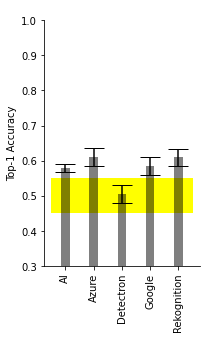

/Users/smadan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
No handles with labels found to put in legend.


mutli_label_recognition_all_35


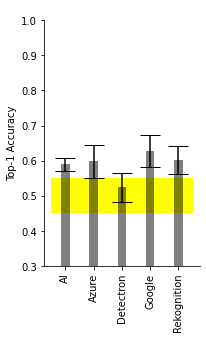

/Users/smadan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
No handles with labels found to put in legend.


mutli_label_recognition_all_35_45


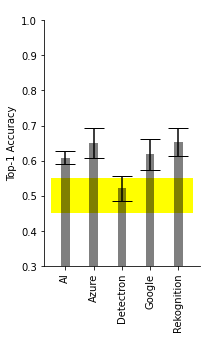

/Users/smadan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
No handles with labels found to put in legend.


mutli_label_recognition_all_45


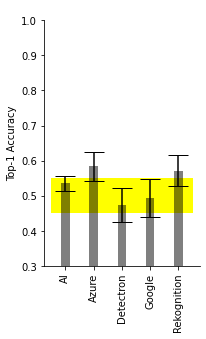

mutli_label_recognition_all_edu_1


/Users/smadan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
No handles with labels found to put in legend.


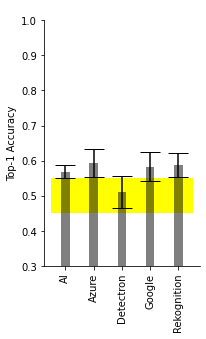

mutli_label_recognition_all_edu_2


/Users/smadan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
No handles with labels found to put in legend.


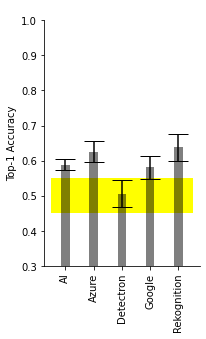

mutli_label_recognition_all_edu_3


/Users/smadan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
No handles with labels found to put in legend.


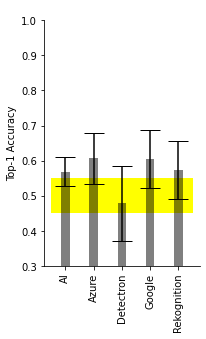

mutli_label_recognition_all_male


/Users/smadan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
No handles with labels found to put in legend.


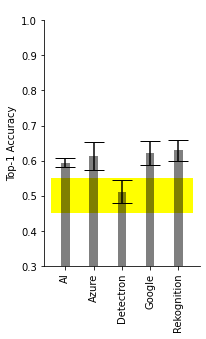

mutli_label_recognition_all_female


/Users/smadan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
No handles with labels found to put in legend.


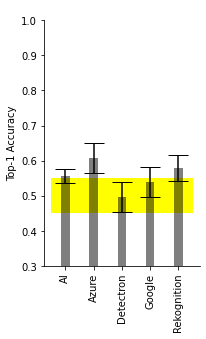

In [40]:
for split in result_conf_mats.keys():
    result_conf_mat = result_conf_mats[split]
    plotname = 'mutli_label_recognition_%s'%split
    all_stds = []
    for key_2 in ['all', 'azure', 'detectron', 'google', 'rekognition']:
        all_stds.append(converted_stds[split][key_2])
    print(plotname)
    plot_graph(result_conf_mat,all_stds,plotname)